# Load Financial database
## Load stock data from CSMAR

In [1]:
from csmarapi.CsmarService import CsmarService
csmar = CsmarService()

In [2]:
# Load DB credentials from .env and log in to CSMAR
# Prerequisite: pip install python-dotenv and create a .env file with DB_USER and DB_PASS
# Security note: avoid hardcoding secrets in notebooks; use environment variables instead.
import os
from dotenv import load_dotenv

# Load variables from .env into the current environment
load_dotenv()

# Read CSMAR credentials (make sure .env defines DB_USER and DB_PASS)
# You can replace these with your actual credentials
user = os.getenv("DB_USER")
pwd  = os.getenv("DB_PASS")

# Authenticate with the CSMAR service using the credentials
csmar.login(user, pwd)

Mon 01 Sep 2025 16:06:46 CsmarService.py INFO User login succeed


In [3]:
# Download stock data for Pingan Bank
data = csmar.query_df( ['Stkcd','Trddt','Opnprc','Hiprc', 'Loprc', 'Clsprc'], 
                      "Stkcd=000001", 'TRD_Dalyr','2006-01-01','2010-12-31')
print(data)

       Stkcd       Trddt  Opnprc  Hiprc  Loprc  Clsprc
0     000001  2006-01-04    6.13   6.33   6.12    6.28
1     000001  2006-01-05    6.30   6.35   6.24    6.32
2     000001  2006-01-06    6.40   6.50   6.35    6.41
3     000001  2006-01-09    6.40   6.44   6.34    6.39
4     000001  2006-01-10    6.35   6.36   6.15    6.28
...      ...         ...     ...    ...    ...     ...
1097  000001  2010-12-27   16.62  16.73  16.02   16.07
1098  000001  2010-12-28   16.08  16.22  15.95   15.95
1099  000001  2010-12-29   15.95  15.98  15.60   15.77
1100  000001  2010-12-30   15.77  15.80  15.51   15.67
1101  000001  2010-12-31   15.68  15.87  15.59   15.79

[1102 rows x 6 columns]


In [4]:
# Export data
data.to_csv('pingan_bank_stock_data.csv', index=False)

<Axes: title={'center': 'Pingan Bank Stock Price (2005-2009)'}, xlabel='Trddt'>

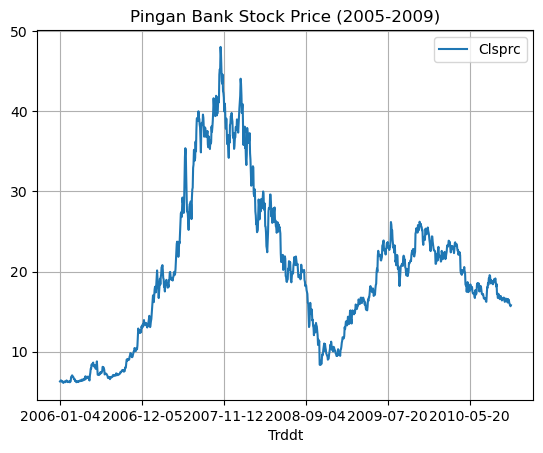

In [ ]:
data.plot(x='Trddt', y='Clsprc', title='Pingan Bank Stock Price (2006-2010)', grid=True)

## Load Microsoft stock data from WRDS

In [6]:
# Download monthly MSFT data (2000-2015) from WRDS CRSP and plot close price
# Prerequisite: pip install wrds; you will be prompted for your WRDS credentials
# Tip: set environment variable WRDS_USERNAME to skip the username prompt
import os
import wrds
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt

load_dotenv()

# Optional: read WRDS username from environment (WRDS_USER)
wrds_user = os.getenv("WRDS_USER")

# Connect to WRDS (prompts for credentials if not cached)
conn = wrds.Connection(wrds_username=wrds_user)

Loading library list...
Done
Done


In [7]:
# Use CRSP monthly stock file (msf) and map MSFT ticker to PERMNO via stocknames
sql = """
WITH msft_perm AS (
  SELECT DISTINCT permno
  FROM crsp.stocknames
  WHERE ticker = 'MSFT'
)
SELECT
  msf.date,
  msf.permno,
  ABS(msf.prc) AS prc,   -- CRSP stores prc possibly negative for bid/ask direction
  msf.cfacpr
FROM crsp.msf AS msf
JOIN msft_perm ap ON msf.permno = ap.permno
WHERE msf.date BETWEEN '2000-01-01' AND '2015-12-31'
ORDER BY msf.date;
"""

# Fetch data (parse date)
df = conn.raw_sql(sql, date_cols=["date"]) 
conn.close()  # close connection when done

In [8]:
df.head()

,date,permno,prc,cfacpr
0,2000-01-31,10107,97.875,2.0
1,2000-02-29,10107,89.375,2.0
2,2000-03-31,10107,106.25,2.0
3,2000-04-28,10107,69.75,2.0
4,2000-05-31,10107,62.5625,2.0


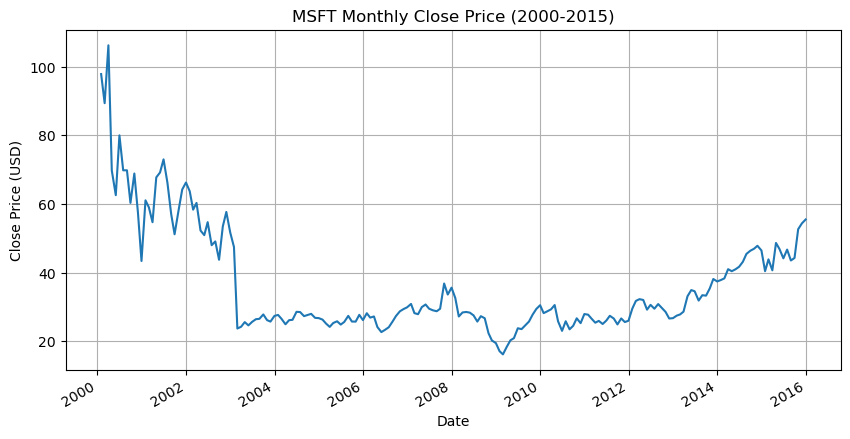

In [9]:
# Plot close (monthly)
df = df.sort_values("date")
ax = df.set_index("date")["prc"].plot(
    figsize=(10, 5),
    title="MSFT Monthly Close Price (2000-2015)",
    grid=True,
)
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
plt.show()

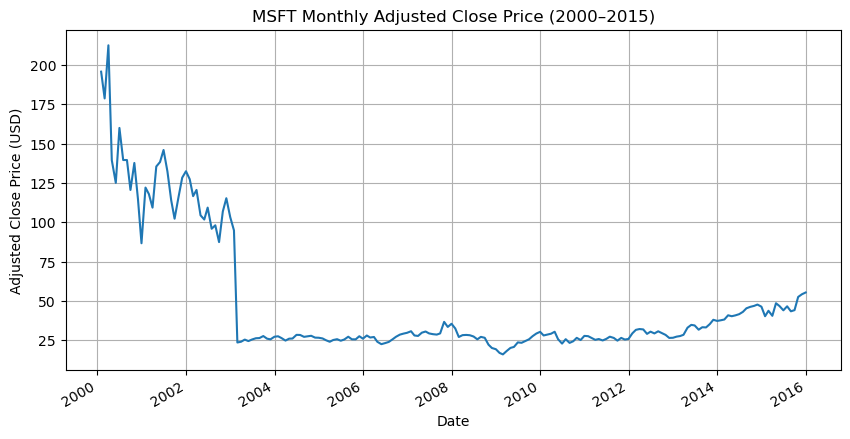

In [10]:
# Optionally compute split-adjusted price (commented out)
df["adj_prc"] = df["prc"] * df["cfacpr"]

# Plot adjusted close (monthly)
df = df.sort_values("date")
ax = df.set_index("date")["adj_prc"].plot(
    figsize=(10, 5),
    title="MSFT Monthly Adjusted Close Price (2000–2015)",
    grid=True,
)
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Close Price (USD)")
plt.show()

# Descriptive Statistics
Descriptive statistics are the cornerstone of empirical research, providing essential diagnostics to ensure the scientific selection of models and the validity of estimation results. This process safeguards empirical analysis through three key steps:

- **1. Data Quality Assessment and Distribution Identification**

    - By calculating statistics such as mean, variance, skewness, and kurtosis, and using visual tools like boxplots and kernel density plots, researchers can systematically identify data anomalies (e.g., outliers), distribution deviations (e.g., right-skewed housing prices), and structural issues. For example, a skewness coefficient greater than 3 suggests the need for log transformation, while high kurtosis warns of outlier interference in parameter estimation.

- **2. Model Assumption Verification**

    - **Stationarity Testing:** The ADF unit root test, combined with time series plots, helps detect non-stationary characteristics in macroeconomic variables like GDP, preventing spurious regressions (e.g., false correlation between ice cream sales and drowning incidents). This guides the use of differencing or cointegration analysis.

    - **Variance Stability Testing:** Time series scatter plots reveal variance trends, while the White test confirms heteroscedasticity. If housing price variance increases with predictors (e.g., White test p < 0.05), OLS should be replaced with weighted least squares (WLS) or generalized linear models (GLM).

    - **Serial Correlation Diagnosis:** Autocorrelation function (ACF) plots and the Ljung-Box test effectively identify autocorrelation issues in ARIMA models, preserving the validity of parameter estimates.

- **3. Model Selection and Optimization**

    - Descriptive statistics directly inform modeling strategies: right-skewed data may require Box-Cox transformation, heteroscedastic series point to WLS estimation, and non-stationary series necessitate vector error correction models (VECM). These preprocessing steps significantly improve the statistical properties of estimators—making OLS estimates not only unbiased but also efficient, and transforming VAR model parameters from inconsistent to consistent estimates.

## Mean, Variance, Extremes, Quantiles, etc.

Can be quickly obtained using the `describe` method in a pandas DataFrame.

In [11]:
import os
import pandas as pd

sp500_df = pd.read_stata(os.path.join('./data/l3/', 'sp500.dta'))
sp500_df.set_index(["caldt"], drop=True, inplace=True)
sp500_df.head()

,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
caldt,,,,,,,,,,
1981-02-02,-0.019400,-0.020806,-0.017969,-0.018723,860671216.0,500,878958424.0,499,126.91,-0.020378
1981-02-03,0.013638,0.012727,0.010229,0.009953,871625274.0,500,860671216.0,499,128.46,0.012213
1981-02-04,0.001049,0.000640,0.005337,0.004980,872201939.0,500,871625274.0,499,128.59,0.001012
1981-02-05,0.008967,0.008120,0.009656,0.009496,879284525.0,500,872201939.0,499,129.63,0.008088
1981-02-06,0.008564,0.008046,0.006735,0.005945,886151310.0,500,879197837.0,498,130.60,0.007483


In [12]:
## The three columns represent:
# ewretx: Equal-Weighted Return (excluding dividends)
# vwretx: Value-Weighted Return (excluding dividends)
# sprtrn: S&P 500 Index Return (including dividends)
sp500_ret = sp500_df.loc[:,['ewretx','vwretx','sprtrn']]
des_stat = sp500_ret.describe().T
des_stat

,count,mean,std,min,25%,50%,75%,max
ewretx,10085.0,0.000483,0.011805,-0.184269,-0.004349,0.000707,0.005726,0.120949
vwretx,10085.0,0.000396,0.011281,-0.194659,-0.004435,0.000576,0.005586,0.115133
sprtrn,10085.0,0.000398,0.011340,-0.204669,-0.004476,0.000550,0.005651,0.115800


## Advanced Metrics

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

### Skewness（偏度）
- $\text{Sample Skewness } \hat{sk}=  T^{-1}{\textstyle \sum_{t=1}^{T}} \frac{(X_t - \hat{\mu})^3}{\hat{\sigma}^3}$  
- Describes the asymmetry of the data distribution
- Financial data characteristics:
    - Right-skewed (positive skewness): extremely high returns but usually low returns.
    - Left-skewed (negative skewness): risk of extreme losses. Most stock returns are negatively skewed, as we will see with the SP500 below.
- Remedies: logarithmic transformation, use of quantile regression models
- Threshold: absolute value > 0.5 is considered significant skewness

In [14]:
des_stat.loc['ewretx','skew'] = stats.skew(sp500_ret.ewretx)
des_stat.loc['vwretx','skew'] = stats.skew(sp500_ret.vwretx)
des_stat.loc['sprtrn','skew'] = stats.skew(sp500_ret.sprtrn)
des_stat

,count,mean,std,min,25%,50%,75%,max,skew
ewretx,10085.0,0.000483,0.011805,-0.184269,-0.004349,0.000707,0.005726,0.120949,-0.577535
vwretx,10085.0,0.000396,0.011281,-0.194659,-0.004435,0.000576,0.005586,0.115133,-0.683769
sprtrn,10085.0,0.000398,0.011340,-0.204669,-0.004476,0.000550,0.005651,0.115800,-0.748029


### Kurtosis（峰度）
- Formula: $\text{Kurtosis } \hat{K} = T^{-1}{\textstyle \sum_{t=1}^{T}} \frac{(X_t - \hat{\mu})^4}{\hat{\sigma}^4}$
- Detects the peakedness / fat-tail characteristics of a distribution
- Financial data features:
    - High kurtosis (>3): higher probability of extreme events than under normal distribution (e.g., Black Swan events)
    - Low kurtosis (<3): smoother fluctuations (e.g., government bond yields)
- Coping strategies: assume t-distribution, apply Extreme Value Theory (EVT)

In [15]:
des_stat.loc['ewretx','kurtosis'] = stats.kurtosis(sp500_ret.ewretx)
des_stat.loc['vwretx','kurtosis'] = stats.kurtosis(sp500_ret.vwretx)
des_stat.loc['sprtrn','kurtosis'] = stats.kurtosis(sp500_ret.sprtrn)
des_stat

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
ewretx,10085.0,0.000483,0.011805,-0.184269,-0.004349,0.000707,0.005726,0.120949,-0.577535,18.343688
vwretx,10085.0,0.000396,0.011281,-0.194659,-0.004435,0.000576,0.005586,0.115133,-0.683769,18.809293
sprtrn,10085.0,0.000398,0.011340,-0.204669,-0.004476,0.000550,0.005651,0.115800,-0.748029,20.606189


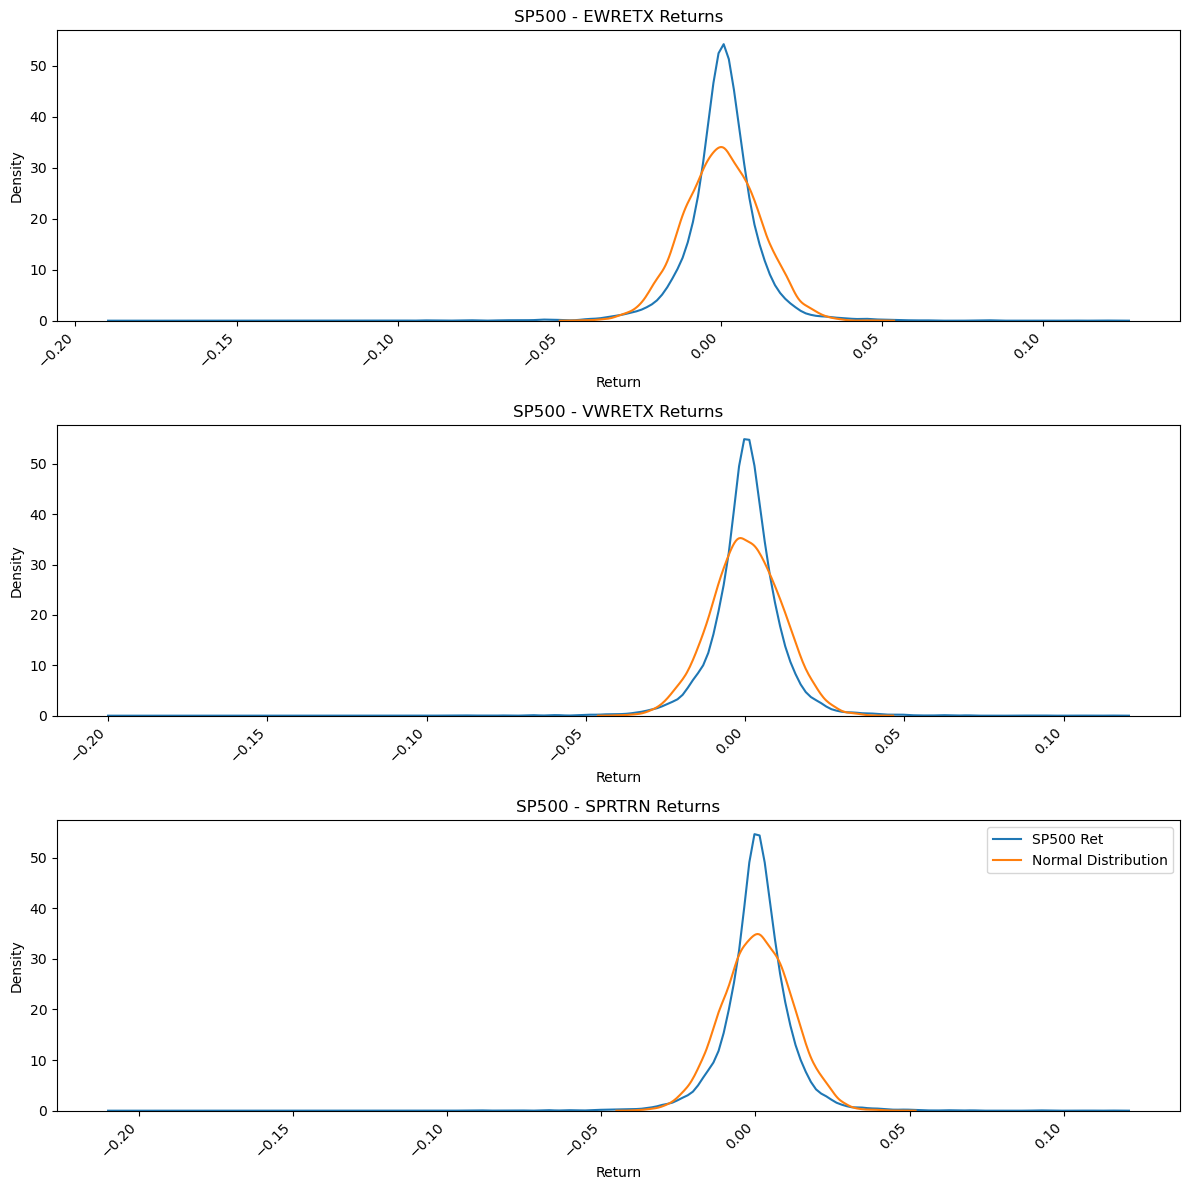

In [16]:
## visualization
# Create a subplot with 3 rows and 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
# Iterate over the three columns of the DataFrame
for i, column in enumerate(['ewretx', 'vwretx', 'sprtrn']):
    # Generate corresponding normal data (same mean and standard deviation)
    normal_data = np.random.normal(loc=des_stat.loc[column,'mean'], scale=des_stat.loc[column,'std'], size=len(sp500_ret.sprtrn))
    
    # Plot histogram and KDE (Kernel Density Estimation) curve
    sns.kdeplot(sp500_ret[column], ax=axes[i], label="SP500 Ret")
    sns.kdeplot(normal_data, ax=axes[i], label="Normal Distribution")
    
    # Set subplot title
    axes[i].set_title(f'SP500 - {column.upper()} Returns')
    
    # Set x-axis label
    axes[i].set_xlabel('Return')
    
    # Set y-axis label
    axes[i].set_ylabel('Density')
    
    # Rotate x-axis labels to avoid overlap
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Adjust spacing between subplots
    plt.tight_layout()

# Set legend
plt.legend(labels=['SP500 Ret','Normal Distribution'])

# Show plot
plt.show()

### Autocorrelation (自相关)
- Formula: $\rho_k = \frac{\text{Cov}(X_t, X_{t-k})}{\sigma_X^2}$
- Problem addressed: lagged dependence in time series (e.g., momentum effect)
- Financial implications:
    - Autocorrelation in stock prices may indicate market inefficiency
    - Residual autocorrelation can lead to biased model estimation
- Coping strategies: differencing, ARIMA/GARCH models


In [17]:
from statsmodels.graphics.tsaplots import plot_acf

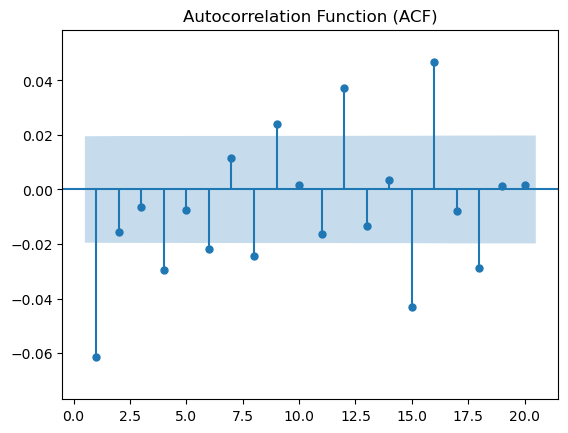

In [18]:
## Plot autocorrelation chart
## Set zero=False to hide the 0th-order autocorrelation, extract autocorrelation coefficients 
## from lag 1 to 20 along with their confidence intervals
plot_acf(sp500_ret.sprtrn, lags=20, alpha=0.05, zero=False, auto_ylims=True)
plt.title("Autocorrelation Function (ACF)")
plt.show()

### Jarque-Bera Test
- Formula: $\text{JB} = \frac{n}{6} \left( S^2 + \frac{(K - 3)^2}{4} \right)$
- $H_0$: Data follows a normal distribution
- Financial applications:
    - Test the normality assumption of asset returns
    - Affects option pricing models (e.g., Black–Scholes model)

In [19]:
def annotate_significance(result):
    """
    Annotate statistical results with significance stars based on p-values.
    
    Parameters:
    result (tuple): Contains the statistic and the corresponding p-value
    
    Returns:
    str: Formatted statistic with significance annotation
    """
    
    # Extract the statistic and p-value
    stat = result[0]
    pvalue = result[1]
    
    # Define a helper function to assign significance symbols based on p-values
    def get_significance(p):
        if p <= 0.01:
            return '***'
        elif p <= 0.05:
            return '**'
        elif p <= 0.1:
            return '*'
        else:
            return ''

    return f"{stat:.2f}{get_significance(pvalue)}"


In [20]:
des_stat.loc['ewretx','JB test'] = annotate_significance(stats.jarque_bera(sp500_ret.ewretx))
des_stat.loc['vwretx','JB test'] = annotate_significance(stats.jarque_bera(sp500_ret.vwretx))
des_stat.loc['sprtrn','JB test'] = annotate_significance(stats.jarque_bera(sp500_ret.sprtrn))
des_stat

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,JB test
ewretx,10085.0,0.000483,0.011805,-0.184269,-0.004349,0.000707,0.005726,0.120949,-0.577535,18.343688,141956.92***
vwretx,10085.0,0.000396,0.011281,-0.194659,-0.004435,0.000576,0.005586,0.115133,-0.683769,18.809293,149451.15***
sprtrn,10085.0,0.000398,0.011340,-0.204669,-0.004476,0.000550,0.005651,0.115800,-0.748029,20.606189,179367.28***


### Augmented Dickey-Fuller (ADF) Test
- $H_0$: The time series has a unit root (non-stationary)  
- $H_a$: The time series is stationary  

- Financial applications:  
    - Test whether asset prices are stationary (e.g., stock prices, exchange rates)  
    - Provide guidance for choosing the differencing order (the $d$ in ARIMA models)  
    - Most financial asset prices are non-stationary, but returns are usually stationary  

- Testing procedure:  
    - Select lag order: often chosen automatically based on AIC or BIC criteria.  
    - Compute test statistic: compare ADF statistic against critical values.  
    - Decision rule:  
        - If p-value < significance level (e.g., 0.05), reject $H_0$, the series is stationary.  
        - Otherwise, fail to reject $H_0$, the series is non-stationary.  

- About stationarity:  
    - Stationarity requires that statistical properties of a time series (e.g., mean, variance, covariance) do not change over time.  
    - Types of stationarity:  
        - *Strict stationarity*: all moments (mean, variance, skewness, etc.) are time-invariant.  
        - *Weak stationarity*: mean and variance are constant; covariance depends only on the lag, not on time.  
    - Importance of stationarity:  
        1. Ensures validity of parameter estimation.  
        2. Prevents spurious regression.  
        3. Allows appropriate statistical inference.  

- How to handle non-stationarity:  
    - **Differencing**: e.g., log stock prices are often non-stationary, but differenced returns are usually stationary.  
    - **Detrending**: for variables with deterministic trends, remove the trend via $X_t = \mu + \sigma t + \varepsilon_t$ to obtain $\varepsilon_t$.  
    - **Cointegration**: if multiple non-stationary series ($I(1)$) have a stable long-term relationship, build an Error Correction Model (ECM).  
      Example: stock prices and dividends may each be non-stationary, but their ratio may be stationary.  

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
des_stat.loc['ewretx','ADF'] = annotate_significance(adfuller(sp500_ret.ewretx))
des_stat.loc['vwretx','ADF'] = annotate_significance(adfuller(sp500_ret.vwretx))
des_stat.loc['sprtrn','ADF'] = annotate_significance(adfuller(sp500_ret.sprtrn))
des_stat

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,JB test,ADF
ewretx,10085.0,0.000483,0.011805,-0.184269,-0.004349,0.000707,0.005726,0.120949,-0.577535,18.343688,141956.92***,-17.36***
vwretx,10085.0,0.000396,0.011281,-0.194659,-0.004435,0.000576,0.005586,0.115133,-0.683769,18.809293,149451.15***,-18.04***
sprtrn,10085.0,0.000398,0.011340,-0.204669,-0.004476,0.000550,0.005651,0.115800,-0.748029,20.606189,179367.28***,-18.05***


### Volatility Clustering（波动率聚类检验）
- Phenomenon: High volatility tends to be followed by high volatility (clustering effect)  
- Autocorrelation test: compute the autocorrelation function of volatility series (e.g., absolute or squared asset returns).  
- Financial implications:  
    - Traditional financial models (e.g., ARMA, CAPM) assume constant volatility, but in reality volatility is time-varying.  
    - The presence of volatility clustering indicates:  
        - Risk asymmetry: negative shocks (e.g., economic recession) usually trigger larger volatility than positive shocks (e.g., favorable policies).  
        - Persistent impact of information shocks: markets may react to sudden events for an extended period (e.g., panic in the early stage of COVID-19 lasted for months).  
- Consequences of ignoring volatility clustering:  
    - Model failure: e.g., when using ARMA models to forecast returns, time-varying volatility can cause forecast intervals to deviate severely from reality.  
    - Statistical inference errors: assuming constant variance may lead to unreliable $t$-test results (e.g., noise during high-volatility periods misinterpreted as signal).  


In [23]:
# Define a function to compute volatility
def compute_volatility(window):
    # Compute mean log return
    mean_log_return = window.mean()
    # Compute squared deviations
    squared_diff = (window - mean_log_return) ** 2
    # Compute variance
    variance = squared_diff.mean()
    # Compute standard deviation (22 trading-day volatility)
    std_dev = np.sqrt(variance)
    # Annualized volatility, assuming 252 trading days per year
    # Since the window is 22 days, the annualization factor is sqrt(252/22)
    annualized_vol = std_dev * np.sqrt(252 / 22)
    return annualized_vol


In [24]:
sp500_ret.loc[:,'ewretx_vol'] = sp500_ret.loc[:,'ewretx'].rolling(window=22, center=False).apply(compute_volatility)
sp500_ret.loc[:,'vwretx_vol'] = sp500_ret.loc[:,'vwretx'].rolling(window=22, center=False).apply(compute_volatility)
sp500_ret.loc[:,'sprtrn_vol'] = sp500_ret.loc[:,'sprtrn'].rolling(window=22, center=False).apply(compute_volatility)

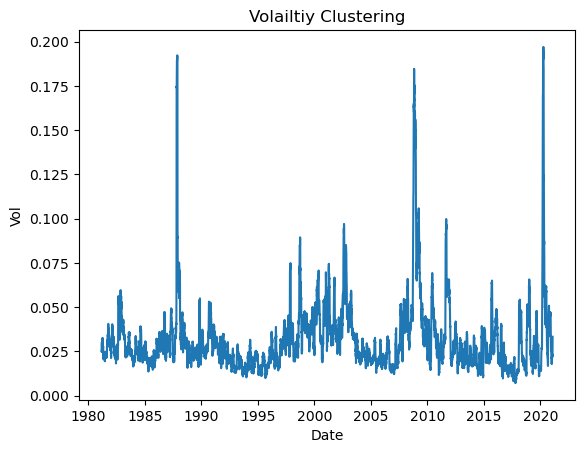

In [25]:
# Visualizing Volatility Clustering
plt.plot(sp500_ret.sprtrn_vol)
plt.title("Volailtiy Clustering")
plt.xlabel("Date")
plt.ylabel("Vol")
plt.show()

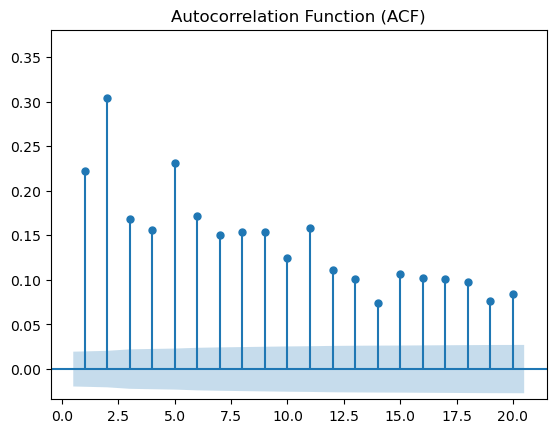

In [26]:
## Autocorrelation test: the autocorrelation function can be computed for volatility series (e.g., absolute or squared asset returns).
plot_acf(sp500_ret.sprtrn**2, lags=20, alpha=0.05, zero=False, auto_ylims=True)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Visualization

In [27]:
macro_df = pd.read_stata(os.path.join('./data/l3/', 'macro.dta'))
macro_df.set_index("datadate", inplace=True, drop=True)
macro_df.head()

,econiso,auto,bond10yr,bond20yr,bond30yr,cabgdp1,cabgdp2,cpi,cpi1,cpi3,...,tbill12m,tbill3m,tbill6m,txcr,unemp,unemp1,unemp2,wpi1,wpi3,wpir
datadate,,,,,,,,,,,,,,,,,,,,,
1981-01-31,ARE,NaN,NaN,NaN,NaN,27.2453,NaN,NaN,32.4246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-02-28,ARE,NaN,NaN,NaN,NaN,27.2453,NaN,NaN,32.4246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-03-31,ARE,NaN,NaN,NaN,NaN,27.2453,NaN,NaN,32.4246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-04-30,ARE,NaN,NaN,NaN,NaN,27.2453,NaN,NaN,32.4246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-05-31,ARE,NaN,NaN,NaN,NaN,27.2453,NaN,NaN,32.4246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
condition = (macro_df.loc[:,'econiso']=='USA')
USAmacro_df = macro_df[condition]
USAmacro_df

,econiso,auto,bond10yr,bond20yr,bond30yr,cabgdp1,cabgdp2,cpi,cpi1,cpi3,...,tbill12m,tbill3m,tbill6m,txcr,unemp,unemp1,unemp2,wpi1,wpi3,wpir
datadate,,,,,,,,,,,,,,,,,,,,,
1981-01-31,USA,647.5,NaN,NaN,12.28,0.1567,0.1230,0.872,41.6980,NaN,...,12.50,14.59,13.63,19.4346,7.5,7.6174,7.4333,51.4771,NaN,9.1426
1981-02-28,USA,764.0,NaN,NaN,12.97,0.1567,0.1230,0.880,41.6980,NaN,...,12.97,14.22,13.89,19.4346,7.4,7.6174,7.4333,51.4771,NaN,9.1426
1981-03-31,USA,962.7,NaN,NaN,12.65,0.1567,0.1230,0.886,41.6980,NaN,...,11.73,12.46,12.03,19.4346,7.4,7.6174,7.4333,51.4771,NaN,9.1426
1981-04-30,USA,751.3,NaN,NaN,13.65,0.1567,0.1551,0.891,41.6980,NaN,...,13.59,14.86,14.21,19.4346,7.2,7.6174,7.4000,51.4771,NaN,9.1426
1981-05-31,USA,733.6,NaN,NaN,13.06,0.1567,0.1551,0.897,41.6980,NaN,...,13.18,15.10,14.02,19.4346,7.5,7.6174,7.4000,51.4771,NaN,9.1426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-08-31,USA,NaN,NaN,NaN,NaN,-1.4096,-1.3876,NaN,141.7744,NaN,...,NaN,NaN,NaN,13.9402,NaN,4.2573,4.2317,139.9098,NaN,1.5734
2030-09-30,USA,NaN,NaN,NaN,NaN,-1.4096,-1.3876,NaN,141.7744,NaN,...,NaN,NaN,NaN,13.9402,NaN,4.2573,4.2317,139.9098,NaN,1.5734
2030-10-31,USA,NaN,NaN,NaN,NaN,-1.4096,-1.3593,NaN,141.7744,NaN,...,NaN,NaN,NaN,13.9402,NaN,4.2573,4.2159,139.9098,NaN,1.5734


## Line Chart
- Show trends: suitable for time series data such as stock prices and returns.  
- Compare multiple series: e.g., comparing returns of different assets.  


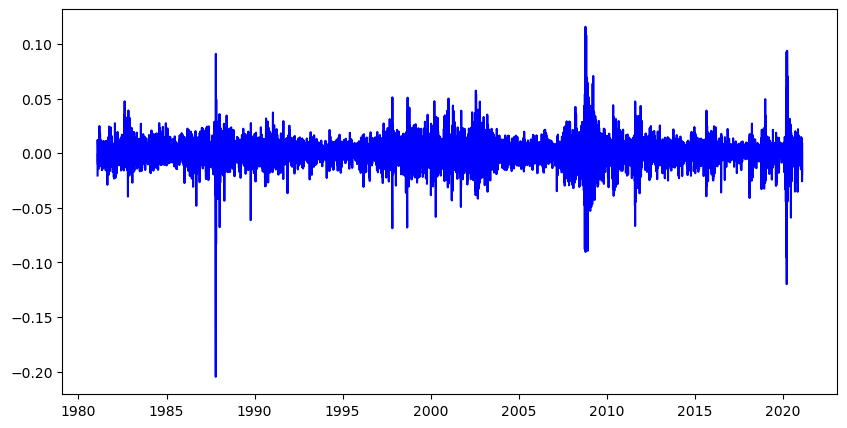

In [29]:
## Daily Returns of the SP500
plt.figure(figsize=(10, 5))
plt.plot(sp500_df.sprtrn, label="SP500", color="blue")
plt.show()

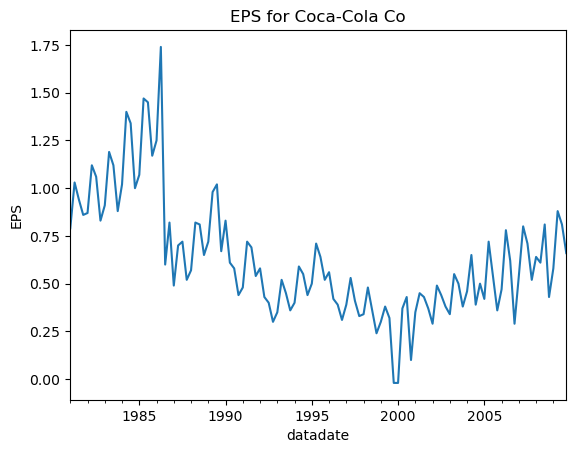

In [30]:
## Seasonality of Earnings
## 收益的季节性
"""
The figure shows Coca-Cola’s earnings per share (EPS) from Q1 1981 to Q4 2009. 
It can be seen that the earnings exhibit a clear annual pattern, 
which in time series analysis is called seasonality.
"""
# Coca-Cola quarterly EPS
cocacola_q = pd.read_pickle(r'.\data\l3\cocacola.pkl')
cocacola_q.set_index("datadate", inplace=True, drop=True)

cocacola_q.loc["1981-03-31":"2009-12-31","epsfxq"].plot()
plt.title("EPS for Coca-Cola Co")
plt.ylabel('EPS')
plt.show()

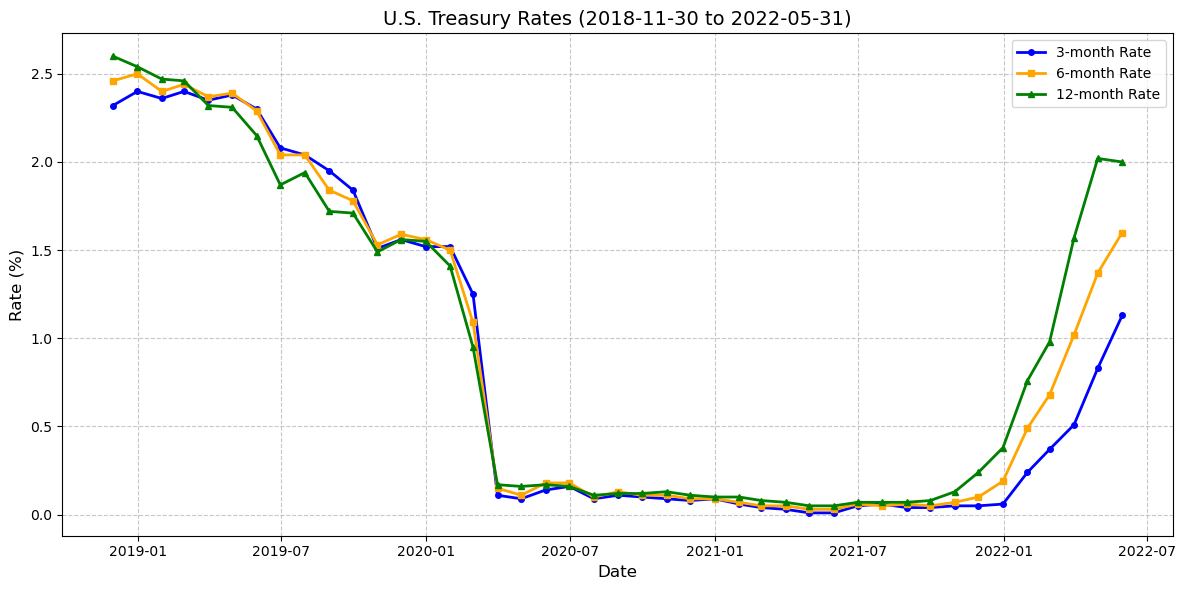

In [31]:
## Yield Curve and Term Structure
"""
Background: Following the emergency 50 basis point rate cut on March 3, 2020, 
the U.S. Federal Reserve further lowered the federal funds rate target range 
by 1 percentage point on March 15, bringing it down to 0%–0.25%. 
Note the period from May 2020 to September 2021, when short-term rates were 
close to zero and the yield curve was flat, reflecting uncertainty about 
economic recovery and dependence on policy.
"""

# Plot three yield curves
plt.figure(figsize=(12, 6))  # Set figure size

# Plot 3-month Treasury yield
plt.plot(USAmacro_df.loc["2018-11-30":"2022-05-31", 'tbill3m'], 
         label='3-month Rate', 
         linestyle='-',  # Solid line
         color='blue',   
         linewidth=2,    
         marker='o',     # Circle markers
         markersize=4)   

# Plot 6-month Treasury yield
plt.plot(USAmacro_df.loc["2018-11-30":"2022-05-31", 'tbill6m'], 
         label='6-month Rate', 
         linestyle='-', 
         color='orange', 
         linewidth=2, 
         marker='s',     # Square markers
         markersize=4)

# Plot 12-month Treasury yield
plt.plot(USAmacro_df.loc["2018-11-30":"2022-05-31", 'tbill12m'], 
         label='12-month Rate', 
         linestyle='-', 
         color='green', 
         linewidth=2, 
         marker='^',     # Triangle markers
         markersize=4)

# Add title and axis labels
plt.title('U.S. Treasury Rates (2018-11-30 to 2022-05-31)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rate (%)', fontsize=12)

# Add legend
plt.legend(loc='upper right', fontsize=10)

# Add grid lines
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show figure
plt.show()


In [32]:
print(USAmacro_df.loc["2015-02-28":"2025-2-28",'unemp'].mean())

4.6652892561983474


In [33]:
print(USAmacro_df.loc["2020-02-28":"2025-2-28",'unemp'].mean())

4.945901639344264


In [34]:
print(USAmacro_df.loc["2020-02-28":"2025-2-28",'cpi'].mean())

2.8967196721311472


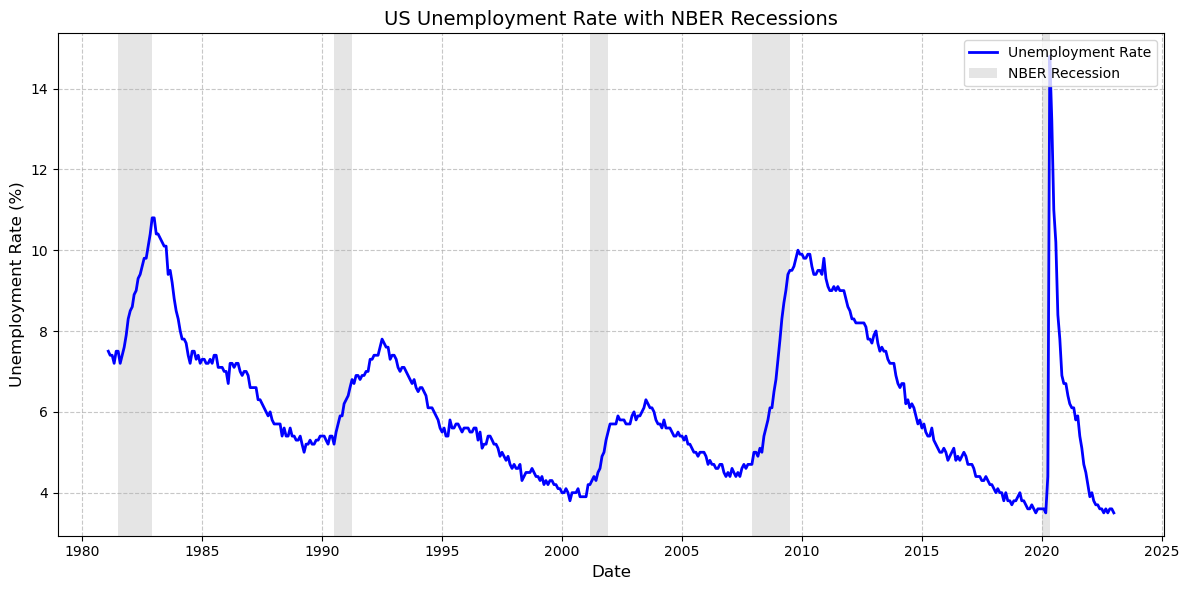

In [35]:
## Economic Recessions and Unemployment Rate
NBERrecession_periods = [('1981-07-01', '1982-11-30'), ('1990-07-01', '1991-03-31'),
                        ('2001-03-01', '2001-11-30'), ('2007-12-01', '2009-06-30'),
                        ('2020-01-01', '2020-04-30')] # Data source: https://www.nber.org/research/business-cycle-dating

# Plot the figure
plt.figure(figsize=(12, 6))

# Plot unemployment rate curve
plt.plot(USAmacro_df.loc["1981-01-31":"2022-12-31",'unemp'], 
         label='Unemployment Rate', 
         color='blue', 
         linewidth=2,)

# Shade recession periods
for start, end in NBERrecession_periods:
    # Use if condition to add legend only once
    if start == NBERrecession_periods[0][0]:
        plt.axvspan(start, end, facecolor='grey', alpha=0.2, label='NBER Recession')
    else:
        plt.axvspan(start, end, facecolor='grey', alpha=0.2)

# Add title and axis labels
plt.title('US Unemployment Rate with NBER Recessions', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unemployment Rate (%)', fontsize=12)

# Add legend
plt.legend(loc='upper right', fontsize=10)

# Add grid lines
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show figure
plt.show()


## Histogram
- Distribution analysis: shows the distribution characteristics of data, such as whether returns follow a normal distribution.  
- Detect outliers: identify extreme values or abnormal distributions.  


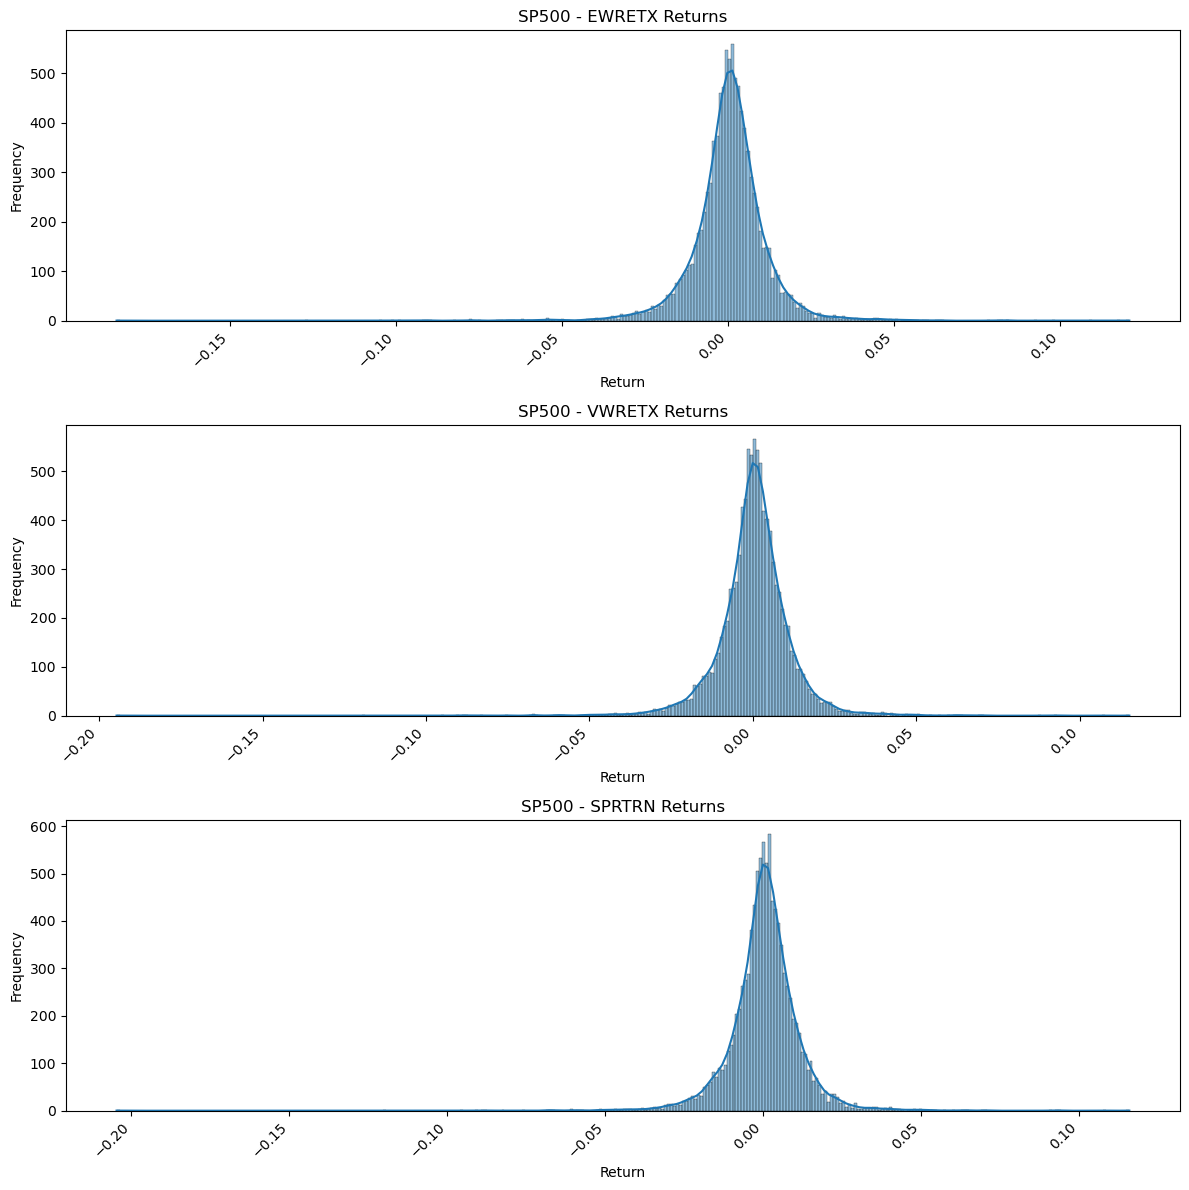

In [36]:
## Visualization
# Create a subplot with 3 rows and 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
# Iterate over the three columns of the DataFrame
for i, column in enumerate(['ewretx', 'vwretx', 'sprtrn']):
    # Plot histogram and KDE curve
    sns.histplot(sp500_ret[column], ax=axes[i], kde=True)
    
    # Set subplot title
    axes[i].set_title(f'SP500 - {column.upper()} Returns')
    
    # Set x-axis label
    axes[i].set_xlabel('Return')
    
    # Set y-axis label
    axes[i].set_ylabel('Frequency')
    
    # Rotate x-axis labels to avoid overlap
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Adjust spacing between subplots
    plt.tight_layout()

# Show figure
plt.show()

## Bar Chart
- Comparison of categorical data: shows the values across different categories.  
- Trend analysis: suitable for categorical time series data (e.g., monthly returns).  


In [37]:
## Obtain Fama-French 25 portfolios
FamaFrench_portfolios = pd.read_pickle(r'.\data\l3\FamaFrench_portfolios.pkl').dropna(subset=['date'])
FamaFrench_portfolios.set_index("date", inplace=True, drop=True)
FamaFrench_portfolios

,s1b1_vwret,s1b2_vwret,s1b3_vwret,s1b4_vwret,s1b5_vwret,s2b1_vwret,s2b2_vwret,s2b3_vwret,s2b4_vwret,s2b5_vwret,...,s4b3_level,s4b4_level,s4b5_level,s5b1_level,s5b2_level,s5b3_level,s5b4_level,s5b5_level,year,month
date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.058275,-0.017005,0.005118,-0.021477,0.019583,0.012117,0.024106,0.006056,-0.026081,-0.004527,...,97.013916,94.616673,95.298804,95.561231,87.746633,96.707291,93.723872,97.905778,1926.0,7.0
1926-08-31,-0.020205,-0.080282,0.013968,0.021482,0.085104,0.023619,-0.007525,0.038984,0.002298,0.062936,...,98.312835,94.878288,97.650588,98.73845,93.091105,98.668999,96.653962,98.456302,1926.0,8.0
1926-09-30,-0.04829,-0.026805,-0.043417,-0.032683,0.008585,-0.026848,-0.005252,0.010789,-0.032877,-0.009419,...,100.253334,96.902516,102.867278,99.742522,96.998604,100.619586,101.962487,106.094148,1926.0,9.0
1926-10-30,-0.093633,-0.035519,-0.035024,0.034413,-0.025451,-0.028013,-0.04419,-0.050767,-0.08027,-0.013212,...,98.476544,98.337255,103.765309,98.450856,100.549723,100.758743,101.198176,103.517758,1926.0,10.0
1926-11-30,0.055888,0.041876,0.024384,-0.044495,0.005109,0.031022,-0.017316,0.030424,0.049538,0.027291,...,96.402825,95.138245,98.211374,95.755173,97.527198,98.494996,96.469692,97.500478,1926.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,-0.01695,-0.04277,-0.026546,-0.037695,-0.021264,0.005129,0.002862,-0.035651,-0.022203,-0.018098,...,4610140.008797,12265956.557863,6469976.73136,1276371.984244,788092.966564,1611987.052,438072.984614,2599243.767334,2024.0,8.0
2024-09-30,0.016419,0.010592,-0.015476,-0.012206,-0.00232,0.005382,0.013042,0.009173,-0.005248,-0.008892,...,4668333.806128,12714130.078574,6384915.947273,1307251.251659,819563.094905,1629114.414427,433075.448005,2585504.16478,2024.0,9.0
2024-10-31,0.053571,0.004751,-0.007511,-0.009102,0.006604,-0.009067,-0.009828,-0.031869,-0.004686,-0.011391,...,4592347.336765,12917518.017441,6482298.685301,1296893.899992,808844.84875,1611555.819268,434644.480354,2737738.650002,2024.0,10.0


In [38]:
## Separate grouped portfolios under different conditions (equal-weighted returns)
FF_s1_portfolios = FamaFrench_portfolios.loc[:,["s1b%d_ewret" % i for i in range(1,6)]]
FF_s2_portfolios = FamaFrench_portfolios.loc[:,["s2b%d_ewret" % i for i in range(1,6)]]
FF_s3_portfolios = FamaFrench_portfolios.loc[:,["s3b%d_ewret" % i for i in range(1,6)]]
FF_s4_portfolios = FamaFrench_portfolios.loc[:,["s4b%d_ewret" % i for i in range(1,6)]]
FF_s5_portfolios = FamaFrench_portfolios.loc[:,["s5b%d_ewret" % i for i in range(1,6)]]

ff_portfolios_s = [
    FF_s1_portfolios,
    FF_s2_portfolios,
    FF_s3_portfolios,
    FF_s4_portfolios,
    FF_s5_portfolios
]

In [39]:
## Separate grouped portfolios under different conditions (equal-weighted returns)
FF_b1_portfolios = FamaFrench_portfolios.loc[:,["s%db1_ewret" % i for i in range(1,6)]]
FF_b2_portfolios = FamaFrench_portfolios.loc[:,["s%db2_ewret" % i for i in range(1,6)]]
FF_b3_portfolios = FamaFrench_portfolios.loc[:,["s%db3_ewret" % i for i in range(1,6)]]
FF_b4_portfolios = FamaFrench_portfolios.loc[:,["s%db4_ewret" % i for i in range(1,6)]]
FF_b5_portfolios = FamaFrench_portfolios.loc[:,["s%db5_ewret" % i for i in range(1,6)]]

ff_portfolios_b = [
    FF_b1_portfolios,
    FF_b2_portfolios,
    FF_b3_portfolios,
    FF_b4_portfolios,
    FF_b5_portfolios
]

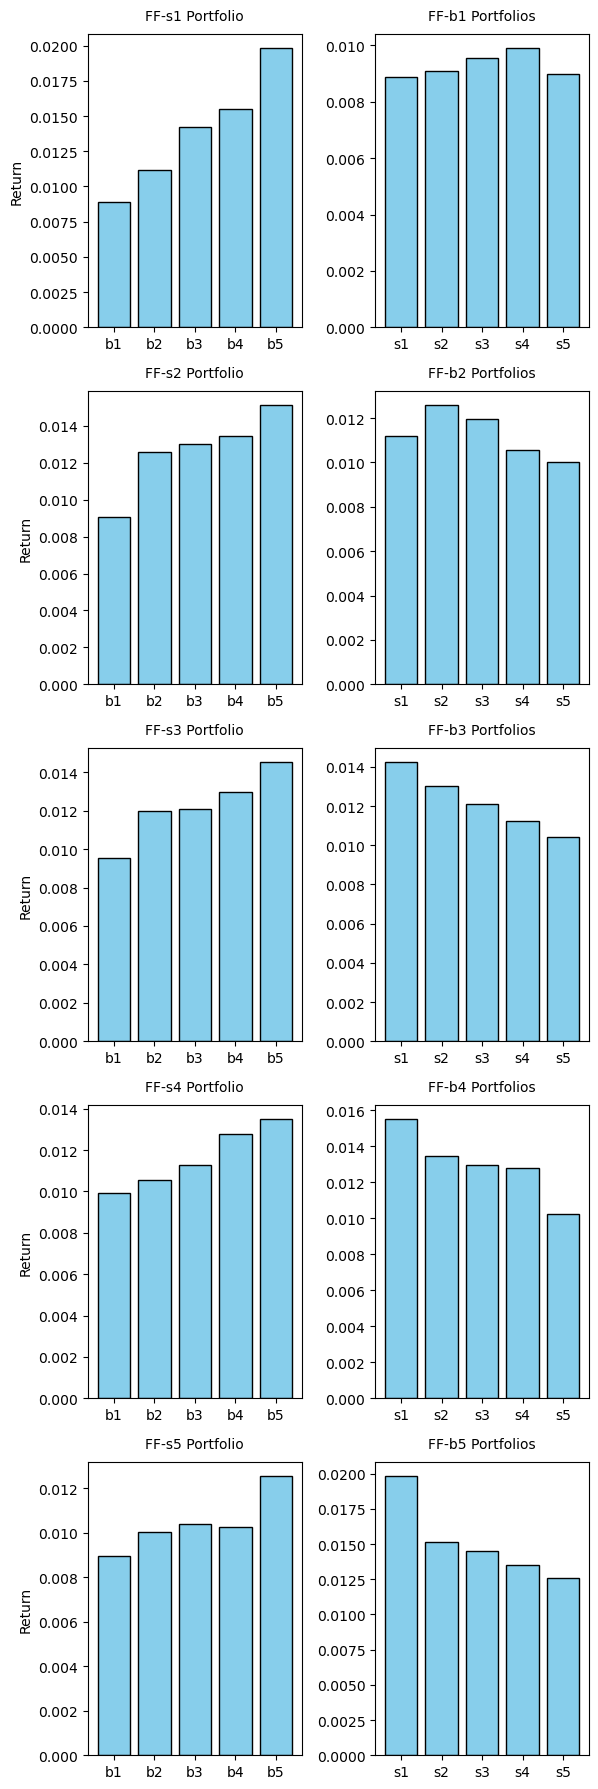

In [40]:
# Create a subplot layout with 5 rows and 2 columns (vertical arrangement)
"""
Size effect: small-cap stocks tend to outperform large-cap stocks in the long run.  
Value effect: stocks with a high book-to-market ratio (value stocks) tend to outperform those with a low book-to-market ratio (growth stocks).  
Risk-return tradeoff: as risk increases (e.g., from b1 -> b5), the required return also increases.  
"""
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(6, 18))  # Adjust figsize to fit multiple subplots

simple_col_s = ["b%d" % i for i in range(1,6)]
simple_col_b = ["s%d" % i for i in range(1,6)]

# Iterate through each subplot and its corresponding DataFrame
for i, ax in enumerate(axes):
    # Get the current DataFrame (assuming ff_portfolios is a list of DataFrames)
    df1 = ff_portfolios_s[i]
    df2 = ff_portfolios_b[i]
    
    ## Plot bar chart — grouped by size
    axes[i, 0].bar(simple_col_s, df1.mean(), color='skyblue', edgecolor='black')
    
    # Set title and axis labels
    axes[i, 0].set_title(f"FF-s{i+1} Portfolio", fontsize=10, pad=10)
    # axes[i, 0].set_xlabel("Portfolio", fontsize=10)
    axes[i, 0].set_ylabel("Return", fontsize=10)
    
    # Configure gridlines and adjust layout
    # axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)
    # axes[i, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels (optional)
    
    ## Plot bar chart — grouped by value
    axes[i, 1].bar(simple_col_b, df2.mean(), color='skyblue', edgecolor='black')
    
    # Set title and axis labels
    axes[i, 1].set_title(f"FF-b{i+1} Portfolios", fontsize=10, pad=10)
    # axes[i, 1].set_xlabel("Portfolio", fontsize=10)
    # axes[i, 1].set_ylabel("Return", fontsize=10)
    
    # Configure gridlines and adjust layout
    # axes[i, 1].grid(axis='y', linestyle='--', alpha=0.7)
    # axes[i, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels (optional)
    

# Adjust spacing between subplots
plt.tight_layout()

# Show figure
plt.show()


## Scatter Plot
- Correlation analysis: shows the relationship between two variables.  
- Clustering analysis: identifies clusters or outliers in the data.  

In [41]:
unemp = USAmacro_df['unemp'].dropna()
infla = USAmacro_df['cpi'].dropna()

scatter_data = pd.concat([unemp, infla], axis=1).sort_values('unemp')
scatter_data

,unemp,cpi
datadate,,
2023-04-30,3.4,3.0286
2022-12-31,3.5,2.9881
2023-01-31,3.5,3.0046
2022-09-30,3.5,2.9642
2023-03-31,3.5,3.0164
...,...,...
1982-12-31,10.8,0.9770
1982-11-30,10.8,0.9800
2020-06-30,11.0,2.5704


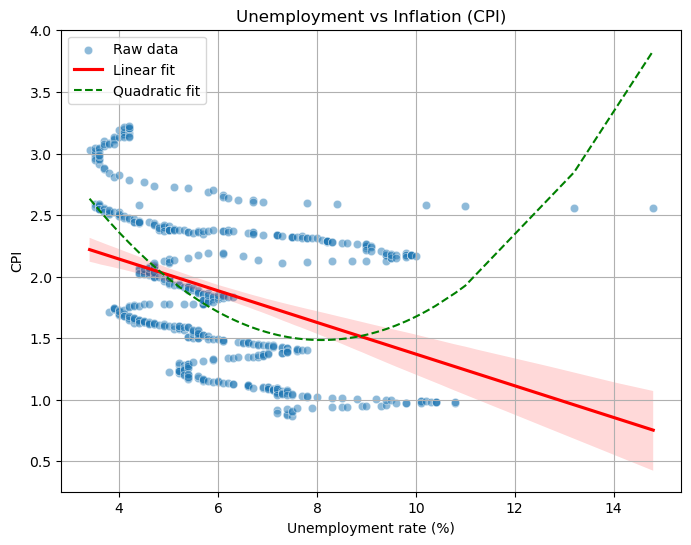

In [42]:
plt.figure(figsize=(8,6))

# --- Raw scatter plot ---
sns.scatterplot(x='unemp', y='cpi', data=scatter_data, alpha=0.5, label='Raw data')

# --- Linear regression fit ---
sns.regplot(x='unemp', y='cpi', data=scatter_data,
            scatter=False, color='red', label='Linear fit')

# --- Optional: Quadratic fit (to capture curvature) ---
X = scatter_data['unemp']
X_quad = sm.add_constant(pd.DataFrame({'x': X, 'x2': X**2}))
y = scatter_data['cpi']
model = sm.OLS(y, X_quad).fit()
scatter_data = scatter_data.sort_values('unemp')
plt.plot(scatter_data['unemp'],
         model.predict(sm.add_constant(pd.DataFrame({'x': scatter_data['unemp'], 'x2': scatter_data['unemp']**2}))),
         color='green', linestyle='--', label='Quadratic fit')

# --- Labels and title ---
plt.title('Unemployment vs Inflation (CPI)')
plt.xlabel('Unemployment rate (%)')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.show()

## Heatmap
- Correlation analysis: shows correlations among multiple variables.  
- Pattern recognition: identifies patterns or clusters in the data.  

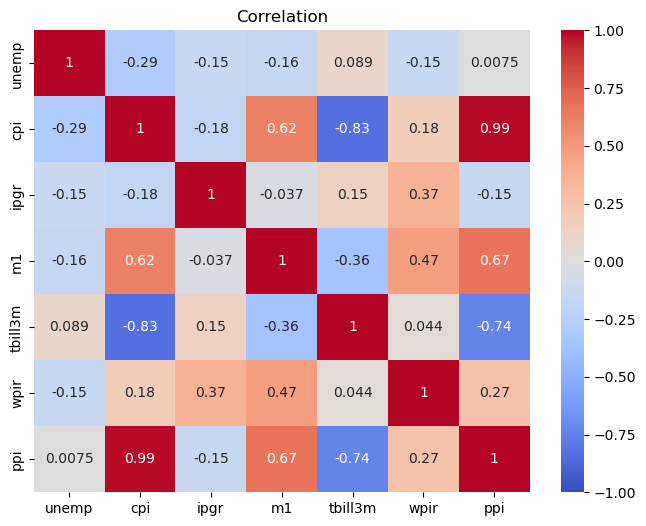

In [43]:
## Correlation
# Variable meanings:
# unemp: Unemployment
# cpi: Consumer Price Index - All Urban - All Items
# ipgr: Industrial Production Index - Growth Rate
# m1: Money Supply - M1
# tbill3m: Treasury Bill - 3 Month
# wpir: Wholesale Price Index - Inflation Rate
# ppi: Producer Price Index - Finished Goods - All Items

correlation_data = USAmacro_df.loc["1981-01-31":"2022-12-31", ["unemp","cpi","ipgr","m1","tbill3m","wpir","ppi"]]

# Compute correlation matrix
corr_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation")
plt.show()

- Heatmaps can also reflect changes in variable importance (across models or over time), especially when dealing with many variables.  
    - Example: Gu et al. (2020) visualized differences in predictor importance across models with variable-importance heatmaps.  
    - Gu, S., Kelly, B., & Xiu, D. (2020). Empirical asset pricing via machine learning. *The Review of Financial Studies*, 33(5), 2223–2273. 

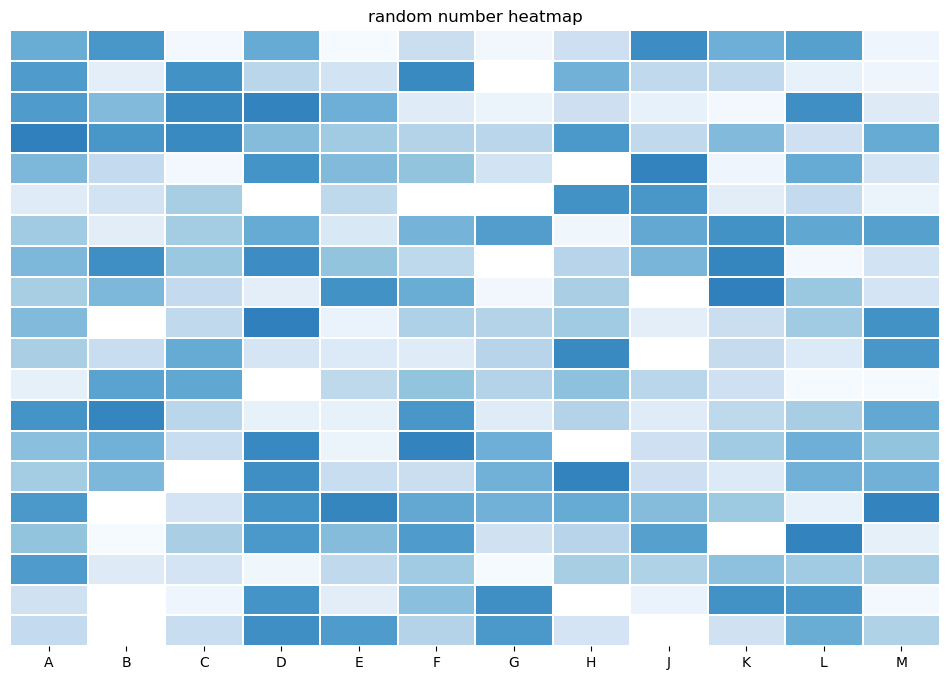

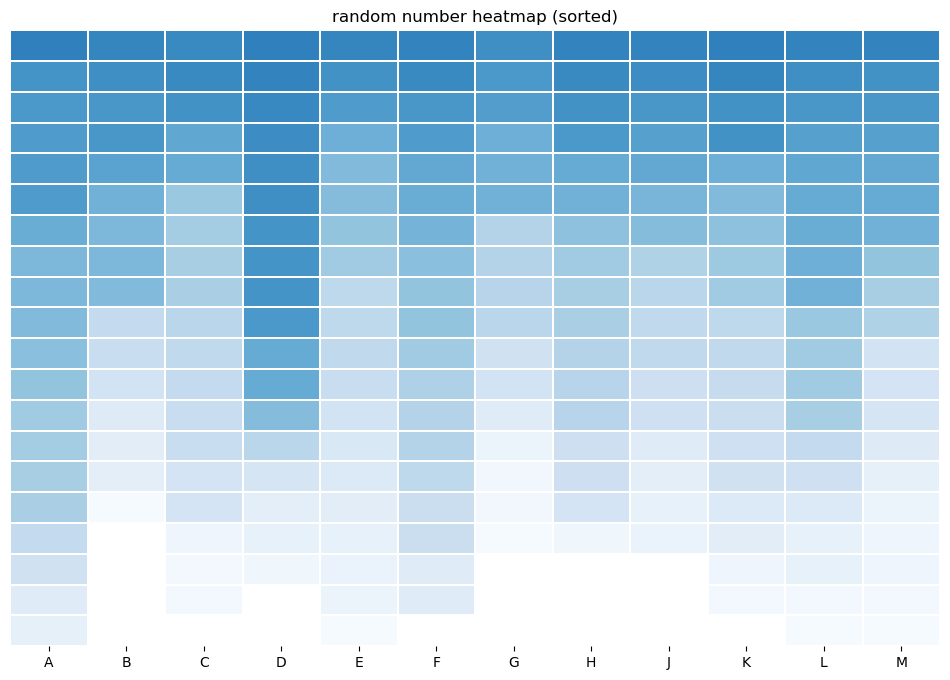

In [44]:
## Example simulation code
# Generate simulated data
rand_matrix = np.random.rand(20, 12)
rand_matrix_sorted = np.sort(rand_matrix,axis=0)[::-1]  # Sort in descending order
data = pd.DataFrame(rand_matrix,columns=[i for i in "ABCDEFGHJKLM"])
data_sorted = pd.DataFrame(rand_matrix_sorted,columns=[i for i in "ABCDEFGHJKLM"])

# Plot heatmap
f, ax = plt.subplots(figsize = (12,8))
new_blues=sns.color_palette("Blues", 100)[0:70]         # Set color scheme (blue-based)
sns.heatmap(data, mask=(data<0.1), cmap=new_blues,yticklabels=False,linewidths = 0.005, linecolor= 'white', ax = ax, cbar = False)
ax.set_title('random number heatmap')

# Plot heatmap (sorted)
f, ax = plt.subplots(figsize = (12,8))
new_blues=sns.color_palette("Blues", 100)[0:70]         
sns.heatmap(data_sorted, mask=(data_sorted<0.1), cmap=new_blues,yticklabels=False,linewidths = 0.005, linecolor= 'white', ax = ax, cbar = False)
ax.set_title('random number heatmap (sorted)')

plt.show()

## Stacked Area Chart
- Multivariable trend analysis: shows the evolution and cumulative effects of multiple variables over time.  
- Proportion analysis: shows the changing shares of components in the total.  


In [45]:
emission_df = pd.read_stata(os.path.join('./data/l3/', 'GW_GHGEMISSIONY.dta'))

In [46]:
# -----------------------------
# 1) Prepare data (annual panel)
# -----------------------------

# Drop regional aggregates
emission_data = emission_df[~emission_df['CountryCode3'].isin(
    {'EAS', 'EUU', 'LCN', 'MEA', 'NAC', 'OED', 'SAS', 'WLD', 'ECS'}
)].rename(columns={'SgnYear': 'year'})

# Keep fields of interest
emission_data = emission_data[['year', 'CountryCode3', 'GHGEmission']].dropna(subset=['GHGEmission'])

# Forward fill within each country for small gaps
emission_data['GHGEmission'] = (
    emission_data.sort_values(['CountryCode3', 'year'])
                 .groupby('CountryCode3')['GHGEmission']
                 .ffill()
)

# Pivot: rows = year, columns = ISO3, values = GHG emission
emission_wide = emission_data.pivot(index='year', columns='CountryCode3', values='GHGEmission').sort_index()
emission_wide.head()


CountryCode3,ABW,AFG,AGO,ALB,ARE,ARG,ARM,ASM,ATG,AUS,...,VEN,VGB,VIR,VNM,VUT,WSM,YEM,ZAF,ZMB,ZWE
year,,,,,,,,,,,,,,,,,,,,,
1970.0,42.3063,14306.6163,60648.6011,6960.8682,32962.1894,221957.0230,6245.9877,13.0734,NaN,319036.599,...,137392.304,31.9016,21.7696,79128.7160,230.1668,116.5772,4839.5209,253769.713,234168.070,24033.927
1971.0,42.7869,14391.7782,39162.1714,6950.0361,41377.8451,213551.7884,6383.6720,13.2473,NaN,314446.149,...,123610.813,29.6487,23.1136,77395.2741,248.1072,117.1735,5099.1964,250418.763,132574.688,21404.869
1972.0,43.2866,13040.8480,42205.6507,7613.2661,44905.4628,223912.2788,6750.8237,13.4481,NaN,355430.771,...,130311.533,35.9350,24.4884,78737.2970,248.2925,117.2924,5353.7458,250958.915,142670.635,21231.400
1973.0,43.7246,13535.7541,44252.6691,7348.4921,56875.5078,226956.0333,7371.7577,13.6753,NaN,333243.563,...,135180.664,37.7852,25.9199,83408.6760,273.7137,119.4629,5678.1841,269278.453,153119.791,23156.252
1974.0,44.1310,14945.9682,40179.2335,7632.6643,57411.5266,229456.3800,7983.8753,13.9088,NaN,355842.865,...,135826.288,35.4963,27.9539,79939.5781,295.9808,130.8247,5872.2931,275680.140,133429.651,22589.525


In [47]:
# -----------------------------
# 2) Select top countries
# -----------------------------
latest_year = emission_wide.index.max()

# Pick top 6 countries by GHG emission in the latest year
top_emitters = (
    emission_wide.loc[latest_year].dropna().sort_values(ascending=False).head(6).index.tolist()
)

# Build dataframe with top emitters + Rest of World
selected_emissions = emission_wide[top_emitters].copy()
rest_of_world = (emission_wide.sum(axis=1) - selected_emissions.sum(axis=1)).clip(lower=0)
selected_emissions['Rest of World'] = rest_of_world

In [48]:
# -----------------------------
# 3) Convert to shares (%)
# -----------------------------
total_emissions = selected_emissions.sum(axis=1)
emission_share = selected_emissions.apply(lambda col: col / total_emissions * 100)


<Figure size 1540x660 with 0 Axes>

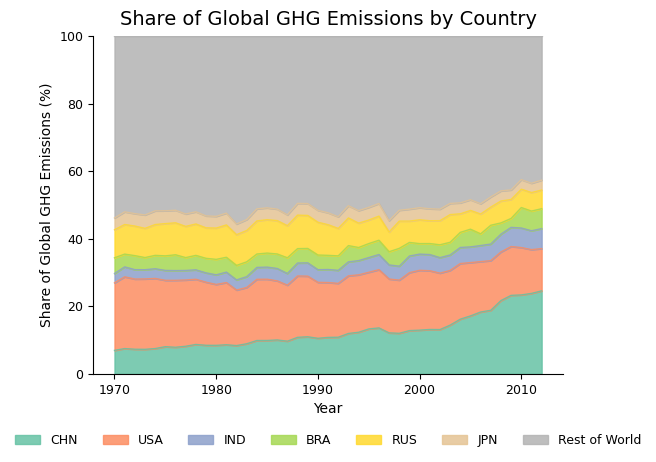

Top emitters (latest year): ['CHN', 'USA', 'IND', 'BRA', 'RUS', 'JPN']


In [49]:
# -----------------------------
# 4) Plot stacked area chart
# -----------------------------
plt.figure(figsize=(14, 6), dpi=110, facecolor='none')

colors = plt.cm.Set2(np.linspace(0, 1, emission_share.shape[1]))

ax = emission_share.plot(
    kind='area',
    stacked=True,
    alpha=0.85,
    linewidth=1,
    color=colors
)

plt.title('Share of Global GHG Emissions by Country', fontsize=14, pad=8)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Share of Global GHG Emissions (%)', fontsize=10)

# Legend formatting
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=min(emission_share.shape[1], 8),
    frameon=False,
    fontsize=9
)

# Axes polish
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 100)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax.set_facecolor('none')

plt.tight_layout()
plt.show()

print("Top emitters (latest year):", top_emitters)

## Box Plot
- Basic principle:
    - The box plot is based on the **five-number summary**, describing data distribution with the following five key values:
        1. Lower bound: the minimum range value: $Q_{min} = Q1 - 1.5 \cdot \text{IQR}$  
        2. First quartile (Q1): the 25th percentile  
        3. Median: the 50th percentile  
        4. Third quartile (Q3): the 75th percentile  
        5. Upper bound: the maximum range value: $Q_{max} = Q3 + 1.5 \cdot \text{IQR}$  
    - Interquartile range (IQR):  
      $\text{IQR} = Q3 - Q1$, which represents the box length  
    - Outliers:  
      $x < Q_{min} \quad \text{or} \quad x > Q_{max}$
- Application scenarios:
    - Compare data distributions across groups (e.g., GDP growth rates by country, profit margins by industry) to visually show central tendency, dispersion, and skewness.  
    - Identify outliers through points beyond the whiskers.  


In [50]:
# -----------------------------
# 1) Filter years and countries
# -----------------------------
yearcondition = (np.array([i for i in range(1970, 2014)] == emission_data.year.values[:, None]).any(axis=1))
countrycondition = (["USA","CHN","JPN","GBR"] == emission_data.CountryCode3.values[:, None]).any(axis=1)

In [51]:
# -----------------------------
# 2) Pivot emission data and compute growth rates
# -----------------------------
emission_growth = (
    emission_data.loc[yearcondition * countrycondition, ['CountryCode3', 'year', 'GHGEmission']]
    .pivot(index='year', columns='CountryCode3', values='GHGEmission')
    .pct_change()   # compute year-over-year growth rate
    .fillna(0)      # fill missing values with 0
)

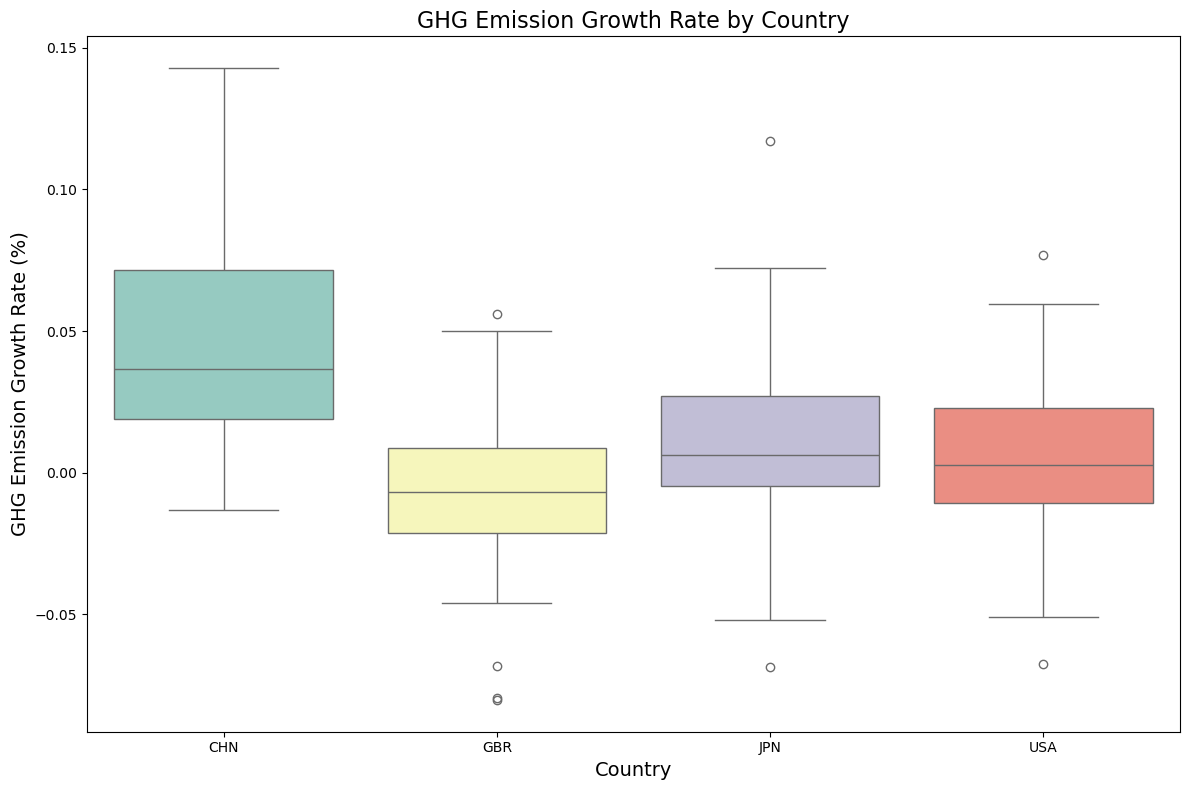

In [52]:
# -----------------------------
# 3) Plot boxplot
# -----------------------------
plt.figure(figsize=(12, 8))
sns.boxplot(data=emission_growth, palette="Set3")

plt.title('GHG Emission Growth Rate by Country', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('GHG Emission Growth Rate (%)', fontsize=14)

plt.tight_layout()
plt.show()

## Map Visualization
- Application scenario: geographical data distribution (e.g., GDP, unemployment rates).  

In [53]:
import plotly.offline as pyo
import plotly.express as px

In [54]:
# --- 1) Filter 2010 data and calculate each country's share of global emissions ---
emission_2010 = (
    emission_data.loc[emission_data['year'] == 2010, ['CountryCode3', 'GHGEmission']]
    .dropna(subset=['GHGEmission'])
    .copy()
)

total_2010 = emission_2010['GHGEmission'].sum()
emission_2010['share_pct'] = emission_2010['GHGEmission'] / total_2010 * 100

hover_name_col = 'CountryCode3'

In [55]:
# --- 2) Plot choropleth map of emission shares ---
fig = px.choropleth(
    emission_2010,
    locations="CountryCode3",
    color="share_pct",
    hover_name=hover_name_col,
    hover_data={
        "CountryCode3": False,       # do not repeat ISO3 code in tooltip
        "GHGEmission": ':.2f',       # show absolute emission values
        "share_pct": ':.2f'          # show share (%)
    },
    color_continuous_scale=px.colors.sequential.Viridis,
    title="Global GHG Emissions Share by Country (2010)",
    labels={"share_pct": "Share of Global GHG Emissions (%)"}
)

# --- 3) Layout adjustments ---
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    margin=dict(l=0, r=0, t=40, b=0),
    coloraxis_colorbar=dict(title="Share (%)")
)

# --- 4) Save and show map ---
pyo.plot(fig, filename='ghg_emission_share_2010_map.html')

# Optional: print total for sanity check
print(f"Total GHG emissions in 2010: {total_2010:,.2f}")

Total GHG emissions in 2010: 47,877,093.87
